In [1]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt

In [33]:
def chung_lu(degree_seq):
    n = len(degree_seq)
    G = nx.Graph()
    for i in range(n):
        G.add_node(i)
    for i in range(n):
        for j in range(i+1, n):
            prob = degree_seq[i]*degree_seq[j]/(2*(sum(degree_seq)))
            if random.random() < prob:
                G.add_edge(i, j)
    return G

In [28]:
degrees=[7,5,5,4,3,2,2,2,1,1,1,1,1,1,1,1]

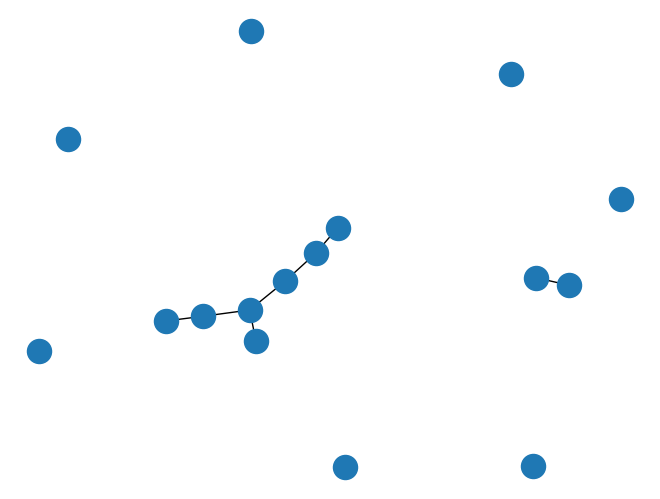

In [34]:
nx.draw(chung_lu(degrees))

In [99]:
def initialize(degree_seq):
    return nx.havel_hakimi_graph(degree_seq)

def pick_double_swap(G):
    edges = list(G.edges())

    edge1, edge2 = random.sample(edges, 2)  

    if len(set(edge1) & set(edge2)) > 0:
        edge1, edge2 = random.sample(edges, 2)
    
     # Get the endpoints of each edge
    a, b = edge1
    c, d = edge2

    # Generate the two possible swaps
    swap1 = [(a,d), (c,b)]
    swap2 = [(a,c), (b,d)]

    # Choose one of the swaps at random
    swap = random.choice([swap1, swap2])

    return swap
    

def is_graph_simple(G):
    """
    Checks whether the given graph is a simple graph (i.e., contains no parallel edges or self-loops).
    Returns True if the graph is simple, False otherwise.
    """
    # Check for parallel edges
    if any(G.has_edge(u, v) and G.has_edge(v, u) for u, v in G.edges()):
        return False

    # Check for self-loops
    if any(u == v for u, v in G.edges()):
        return False

    return True

def apply_swap(G, swap):
    
    # Apply the swap
    new_G = nx.Graph(G)
    new_G.remove_edges_from([swap[0], swap[1]])
    e1 = swap[0][0], swap[1][1]
    e2 = swap[1][0], swap[0][1]
    new_G.add_edges_from([e1, e2])

    if is_graph_simple(new_G):
        return new_G
    else: return G
 
def MCMC(degree_seq):
    G = initialize(degree_seq)
    for _ in range(10):
        swap_edges = pick_double_swap(G)
        G = apply_swap(G, swap_edges)
    return G

In [101]:
test = MCMC(degrees)

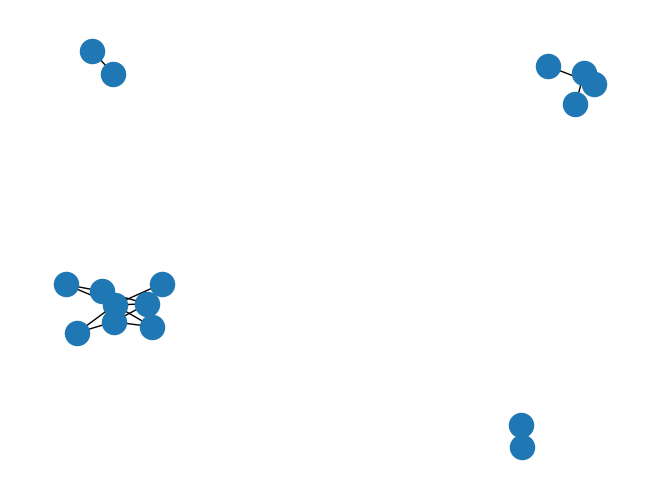

In [102]:
nx.draw(test)

QUESTION 4


In [2]:
def count_edges_between_communities(G, b, community1, community2):
    num_nodes = len(G.nodes)
    nodes_community1 = [i for i in range(num_nodes) if b[i] == community1]
    nodes_community2 = [j for j in range(num_nodes) if b[j] == community2]

    edges_between_communities = G.subgraph(nodes_community1 + nodes_community2).number_of_edges()
    return edges_between_communities

In [3]:
def profile_log_likelihood(G, b):
    n = G.number_of_nodes()
    k = np.array(list(dict(G.degree()).values()))
    L = 0
    community_types = set(b)

    # Iterate over the groups
    for r in community_types:
        nodes_r = np.where(b == r)[0] # get the nodes that are in group r for the degree sum.
        k_r = np.sum(k[nodes_r])

        for s in community_types:
            nodes_s = np.where(b == s)[0]
            k_s = np.sum(k[nodes_s])
            m_rs = count_edges_between_communities(G, b, r, s)
            L += m_rs * np.log(m_rs / k_s*k_r)

    return L / 2

In [4]:
def init(G):
    b = [0]* len(G.nodes)
    p = 0.5
    for node in range(G.number_of_nodes()):
        if p < random.uniform(0,1):
            b[node] = 1
        else: b[node] = 2
    
    logL = profile_log_likelihood(G, np.array(b))
    return np.array(b), logL

In [5]:
def optimization(G, b):
     logL = []
     sum_logL = profile_log_likelihood(G, np.array(b))
     logL.append(sum_logL)
     bPrime = b.copy()
     freeNodes = set(G.nodes())
     frozenNodes = set()
     partition = []

     while len(freeNodes) != 0:
          deltas = {}
          for node in freeNodes:
               if b[node] == 1:
                    bPrime[node] = 2
               else: bPrime[node] = 1
               
          deltas[node] = (profile_log_likelihood(G,b)-profile_log_likelihood(G,bPrime))

          maxDelta = max(deltas, key=deltas.get)
          
          # update b values
          if b[maxDelta] == 1:
               b[maxDelta] = 2
          else: b[maxDelta] = 1

          sum_logL += deltas[maxDelta]
          logL.append(sum_logL)
          partition.append(b)

          freeNodes.remove(maxDelta)
          frozenNodes.add(maxDelta)

     #matrix = np.column_stack([logL, partion])

     best_logL = np.array(logL).argmax()
     best_partition = partition[best_logL]
     
     return logL, best_partition


In [6]:
def load_community_assignments(filename):
    b = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            node, community = line.split('\t')
            b.append(int(community))
    return np.array(b)

def load_graph_from_file(filename):
    G = nx.Graph()
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            node1, node2 = line.split('\t')
            G.add_edge(int(node1) - 1, int(node2) - 1)
    return G

In [7]:
def graph_network(G, b):
    n = G.number_of_nodes()
    color_map = []

    for i in range(n):
        if b[i] == 1:
            color_map.append('red')
        else: 
            color_map.append('blue')    

    nx.draw(G, node_color=color_map)
    plt.show()

In [13]:
# group_file = '/Users/cameronhudson/Documents/Masters/S2/Networks/karate_groups.txt'
# graph_file = '/Users/cameronhudson/Documents/Masters/S2/Networks/karate_edges_77.txt'

group_file = 'karate_groups.txt'
graph_file = 'karate_edges_77.txt'

G = load_graph_from_file(graph_file)
b = load_community_assignments(group_file)

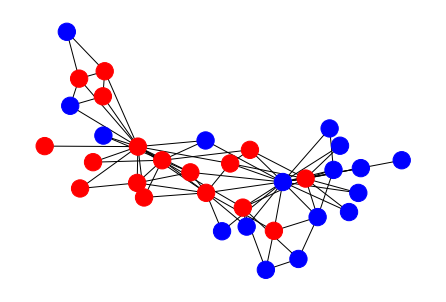

In [14]:
graph_network(G,b)

In [21]:
def run(G, b):
    b, _L = init(G)
    logL, best_partition = optimization(G, b)
    logL, partition = optimization(G, best_partition)

    return logL, partition

In [28]:
logL, partition = run(G, b)

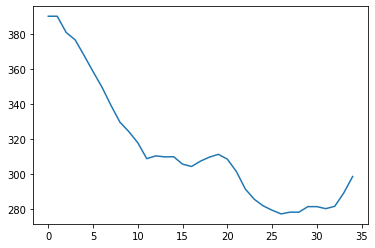

In [29]:
plt.plot(logL)

In [30]:
partition

array([1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2,
       1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2])

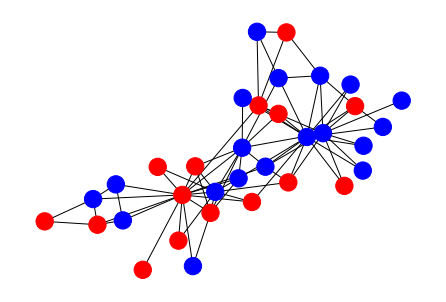

In [31]:
graph_network(G, partition)

In [32]:
def termination(G, b):
    logL, best_partition = optimization(G, b)
    while True:
        new_partition = optimization(G, best_partition)[1]
        new_logL = profile_log_likelihood(G, new_partition)
        if new_logL > logL[-1]:
            logL.append(new_logL)
            best_partition = new_partition
        else:
            break
    return logL, best_partition


C:\Users\alexp\AppData\Local\Temp\ipykernel_35464\105698196.py:16: RuntimeWarning: divide by zero encountered in log
  L += m_rs * np.log(m_rs / k_s*k_r)
C:\Users\alexp\AppData\Local\Temp\ipykernel_35464\105698196.py:16: RuntimeWarning: invalid value encountered in double_scalars
  L += m_rs * np.log(m_rs / k_s*k_r)


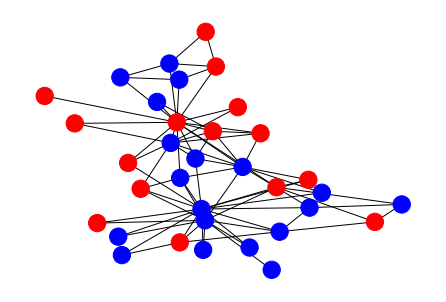

In [40]:
logL, best_partition = termination(G,b)
graph_network(G, partition)


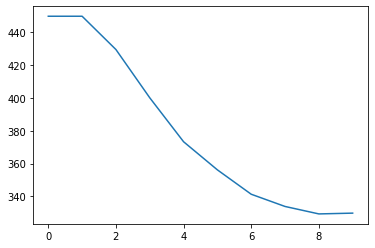

In [41]:
plt.plot(logL)